### [Reference](https://github.com/krishnakartik1/LSTM-footballMatchWinner)

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

# making all pandas columns visable with display command
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('datasets/EPL_sort.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='ignore')
df = df.rename(columns={'date':'Date', 'home_team_api_id':'HomeTeam','away_team_api_id':'AwayTeam',
                        'home_team_goal':'FTHG','away_team_goal':'FTAG','Result':'FTR'})
df

,id,season,stage,Date,match_api_id,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A,home_y_card,home_r_card,away_y_card,away_r_card,home_shoton,away_shoton,home_shotoff,away_shotoff,home_foulcommit,away_foulcommit,home_cross,away_cross,home_corner,away_corner,home_possession,away_possession,HTP,ATP,FTR
1,1730,2008/2009,1,2008-08-16,489043,Arsenal,West Bromwich Albion,1,0,1.20,6.50,15.00,0,0,0,0,12,2,13,3,11,9,21,7,7,5,66,34,0,0,H
7,1736,2008/2009,1,2008-08-16,489049,Bolton Wanderers,Stoke City,3,1,1.83,3.50,4.50,1,0,2,0,5,1,7,6,14,15,22,29,4,3,47,53,0,0,H
5,1734,2008/2009,1,2008-08-16,489047,Everton,Blackburn Rovers,2,3,2.00,3.30,4.00,2,0,2,0,2,8,7,8,11,11,14,21,3,4,51,49,0,0,A
8,1737,2008/2009,1,2008-08-16,489050,Hull City,Fulham,2,1,2.60,3.20,2.80,3,0,0,0,5,4,5,6,10,9,16,14,5,6,53,47,0,0,H
6,1735,2008/2009,1,2008-08-16,489048,Middlesbrough,Tottenham Hotspur,2,1,3.20,3.40,2.25,1,0,2,0,7,2,5,5,11,11,25,27,7,9,53,47,0,0,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976,4705,2015/2016,38,2016-05-15,1987603,Stoke City,West Ham United,2,1,3.50,3.60,2.15,3,0,1,0,3,10,2,7,8,12,13,18,4,10,45,55,48,62,H
2977,4706,2015/2016,38,2016-05-15,1987604,Swansea City,Manchester City,1,1,6.00,4.75,1.53,1,0,3,0,1,5,2,12,5,19,14,15,4,4,50,50,46,65,D
2978,4707,2015/2016,38,2016-05-15,1987605,Watford,Sunderland,2,2,2.05,3.75,3.70,1,0,0,0,6,2,10,2,10,9,9,12,7,4,49,51,44,38,D
2979,4708,2015/2016,38,2016-05-15,1987606,West Bromwich Albion,Liverpool,1,1,2.40,3.60,3.00,3,0,1,0,5,3,8,3,12,13,12,14,7,5,33,67,42,59,D


In [3]:
raw_data_1516 = df[df['season'] == '2015/2016']
raw_data_1415 = df[df['season'] == '2014/2015']
raw_data_1314 = df[df['season'] == '2013/2014']
raw_data_1213 = df[df['season'] == '2012/2013']
raw_data_1112 = df[df['season'] == '2011/2012']
raw_data_1011 = df[df['season'] == '2010/2011']
raw_data_0910 = df[df['season'] == '2009/2010']
raw_data_0809 = df[df['season'] == '2008/2009']

In [4]:
columns_req = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR']

In [5]:
playing_statistics_1516=raw_data_1516[columns_req]
playing_statistics_1415=raw_data_1415[columns_req]
playing_statistics_1314=raw_data_1314[columns_req]
playing_statistics_1213=raw_data_1213[columns_req]
playing_statistics_1112=raw_data_1112[columns_req]
playing_statistics_1011=raw_data_1011[columns_req]
playing_statistics_0910=raw_data_0910[columns_req]
playing_statistics_0809=raw_data_0809[columns_req]
playing_statistics_1516.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
2661,2015-08-08,Bournemouth,Aston Villa,0,1,A
2662,2015-08-08,Chelsea,Swansea City,2,2,D
2663,2015-08-08,Everton,Watford,2,2,D
2664,2015-08-08,Leicester City,Sunderland,4,2,H
2665,2015-08-08,Manchester United,Tottenham Hotspur,1,0,H


In [6]:
def get_goals_scored(playing_stat):
    print("get_goals_scored")
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
#         print("check {} \n".format(i))
        teams[i] = []
    
    # the value corresponding to keys is a list containing the match location.
    for i in range(len(playing_stat)):
        HTGS = playing_stat.iloc[i]['FTHG']
        ATGS = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGS)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGS)
        
    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsScored = pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
    GoalsScored[0] = 0
    # Aggregate to get uptil that point
    for i in range(2,39):
        GoalsScored[i] = GoalsScored[i] + GoalsScored[i-1]
    return GoalsScored



# Gets the goals conceded agg arranged by teams and matchweek
def get_goals_conceded(playing_stat):
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
#         print("check {} \n".format(i))
        teams[i] = []
    
    # the value corresponding to keys is a list containing the match location.
    for i in range(len(playing_stat)):
        ATGC = playing_stat.iloc[i]['FTHG']
        HTGC = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGC)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGC)
    
    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsConceded = pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
    GoalsConceded[0] = 0
    # Aggregate to get uptil that point
    for i in range(2,len(teams["Arsenal"])+1):
        GoalsConceded[i] = GoalsConceded[i] + GoalsConceded[i-1]
    return GoalsConceded

def get_gss(playing_stat):
    GC = get_goals_conceded(playing_stat)
    GS = get_goals_scored(playing_stat)
   
    j = 0
    HTGS = []
    ATGS = []
    HTGC = []
    ATGC = []

    for i in range(380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTGS.append(GS.loc[ht][j])
        ATGS.append(GS.loc[at][j])
        HTGC.append(GC.loc[ht][j])
        ATGC.append(GC.loc[at][j])
        
        if ((i + 1)% 10) == 0:
            j = j + 1
    
#     print("check line 87")
#     print(playing_stat.shape,len(HTGS))
    
    playing_stat['HTGS'] = HTGS
    playing_stat['ATGS'] = ATGS
    playing_stat['HTGC'] = HTGC
    playing_stat['ATGC'] = ATGC
    
    return playing_stat

# Apply to each dataset
playing_statistics_1516=get_gss(playing_statistics_1516)
playing_statistics_1415=get_gss(playing_statistics_1415)
playing_statistics_1314=get_gss(playing_statistics_1314)
playing_statistics_1213=get_gss(playing_statistics_1213)
playing_statistics_1112=get_gss(playing_statistics_1112)
playing_statistics_1011=get_gss(playing_statistics_1011)
playing_statistics_0910=get_gss(playing_statistics_0910)
playing_statistics_0809=get_gss(playing_statistics_0809)

get_goals_scored
get_goals_scored
get_goals_scored
get_goals_scored
get_goals_scored
get_goals_scored
get_goals_scored
get_goals_scored


In [7]:
playing_statistics_1516.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC
2976,2016-05-15,Stoke City,West Ham United,2,1,H,39,64,54,49
2977,2016-05-15,Swansea City,Manchester City,1,1,D,41,70,51,40
2978,2016-05-15,Watford,Sunderland,2,2,D,38,46,48,60
2979,2016-05-15,West Bromwich Albion,Liverpool,1,1,D,33,62,47,49
2973,2016-05-17,Manchester United,Bournemouth,3,1,H,46,44,34,64


In [8]:
def get_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0
    

def get_cuml_points(matchres):
    matchres_points = matchres.applymap(get_points)
    for i in range(2,31):
        matchres_points[i] = matchres_points[i] + matchres_points[i-1]
        
    matchres_points.insert(column =0, loc = 0, value = [0*i for i in range(20)])
    return matchres_points


def get_matchres(playing_stat):
#     print("here")
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        if playing_stat.iloc[i].FTR == 'H':
            teams[playing_stat.iloc[i].HomeTeam].append('W')
            teams[playing_stat.iloc[i].AwayTeam].append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            teams[playing_stat.iloc[i].AwayTeam].append('W')
            teams[playing_stat.iloc[i].HomeTeam].append('L')
        else:
            teams[playing_stat.iloc[i].AwayTeam].append('D')
            teams[playing_stat.iloc[i].HomeTeam].append('D')
            
    return pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T

def get_agg_points(playing_stat):
    matchres = get_matchres(playing_stat)
    cum_pts = get_cuml_points(matchres)
    HTP = []
    ATP = []
    j = 0
    for i in range(380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTP.append(cum_pts.loc[ht][j])
        ATP.append(cum_pts.loc[at][j])

        if ((i + 1)% 10) == 0:
            j = j + 1
            
    playing_stat['HTP'] = HTP
    playing_stat['ATP'] = ATP
    return playing_stat
    
# Apply to each dataset
playing_statistics_1516=get_agg_points(playing_statistics_1516)
playing_statistics_1415=get_agg_points(playing_statistics_1415)
playing_statistics_1314=get_agg_points(playing_statistics_1314)
playing_statistics_1213=get_agg_points(playing_statistics_1213)
playing_statistics_1112=get_agg_points(playing_statistics_1112)
playing_statistics_1011=get_agg_points(playing_statistics_1011)
playing_statistics_0910=get_agg_points(playing_statistics_0910)
playing_statistics_0809=get_agg_points(playing_statistics_0809)

In [9]:
playing_statistics_1516.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP
2976,2016-05-15,Stoke City,West Ham United,2,1,H,39,64,54,49,0,3
2977,2016-05-15,Swansea City,Manchester City,1,1,D,41,70,51,40,3,1
2978,2016-05-15,Watford,Sunderland,2,2,D,38,46,48,60,0,3
2979,2016-05-15,West Bromwich Albion,Liverpool,1,1,D,33,62,47,49,1,1
2973,2016-05-17,Manchester United,Bournemouth,3,1,H,46,44,34,64,0,1


In [10]:
def get_form(playing_stat,num):
    form = get_matchres(playing_stat)
    form_final = form.copy()
    for i in range(num,39):
        form_final[i] = ''
        j = 0
        while j < num:
            form_final[i] += form[i-j]
            j += 1           
    return form_final

def add_form(playing_stat,num):
    form = get_form(playing_stat,num)
    h = ['M' for i in range(num * 10)]  # since form is not available for n MW (n*10)
    a = ['M' for i in range(num * 10)]
    
    j = num
    for i in range((num*10),380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        
        past = form.loc[ht][j]               # get past n results
        h.append(past[num-1])                    # 0 index is most recent
        
        past = form.loc[at][j]               # get past n results.
        a.append(past[num-1])                   # 0 index is most recent
        
        if ((i + 1)% 10) == 0:
            j = j + 1
    
    playing_stat['HM' + str(num)] = h[:playing_stat.shape[0]]                 
    playing_stat['AM' + str(num)] = a[:playing_stat.shape[0]]

    
    return playing_stat


def add_form_df(playing_statistics):
    playing_statistics = add_form(playing_statistics,1)
    playing_statistics = add_form(playing_statistics,2)
    playing_statistics = add_form(playing_statistics,3)
    playing_statistics = add_form(playing_statistics,4)
    playing_statistics = add_form(playing_statistics,5)
    return playing_statistics    
    
# Make changes to df
playing_statistics_1516=add_form_df(playing_statistics_1516)
playing_statistics_1415=add_form_df(playing_statistics_1415)
playing_statistics_1314=add_form_df(playing_statistics_1314)
playing_statistics_1213=add_form_df(playing_statistics_1213)
playing_statistics_1112=add_form_df(playing_statistics_1112)
playing_statistics_1011=add_form_df(playing_statistics_1011)
playing_statistics_0910=add_form_df(playing_statistics_0910)
playing_statistics_0809=add_form_df(playing_statistics_0809)

In [11]:
playing_statistics_1516

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5
2661,2015-08-08,Bournemouth,Aston Villa,0,1,A,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
2662,2015-08-08,Chelsea,Swansea City,2,2,D,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
2663,2015-08-08,Everton,Watford,2,2,D,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
2664,2015-08-08,Leicester City,Sunderland,4,2,H,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
2665,2015-08-08,Manchester United,Tottenham Hotspur,1,0,H,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976,2016-05-15,Stoke City,West Ham United,2,1,H,39,64,54,49,0,3,L,W,D,L,L,W,L,W,L,D
2977,2016-05-15,Swansea City,Manchester City,1,1,D,41,70,51,40,3,1,W,D,W,L,L,W,L,D,W,W
2978,2016-05-15,Watford,Sunderland,2,2,D,38,46,48,60,0,3,L,W,L,W,W,D,L,D,W,W
2979,2016-05-15,West Bromwich Albion,Liverpool,1,1,D,33,62,47,49,1,1,D,D,L,W,D,L,L,D,L,W


In [12]:
cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3',
        'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5' ]

playing_statistics_1516=playing_statistics_1516[cols]
playing_statistics_1415=playing_statistics_1415[cols]
playing_statistics_1314=playing_statistics_1314[cols]
playing_statistics_1213=playing_statistics_1213[cols]
playing_statistics_1112=playing_statistics_1112[cols]
playing_statistics_1011=playing_statistics_1011[cols]
playing_statistics_0910=playing_statistics_0910[cols]
playing_statistics_0809=playing_statistics_0809[cols]

In [13]:
playing_statistics_1516.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5
2976,2016-05-15,Stoke City,West Ham United,2,1,H,39,64,54,49,0,3,L,D,L,L,L,W,L,W,W,D
2977,2016-05-15,Swansea City,Manchester City,1,1,D,41,70,51,40,3,1,W,W,L,L,W,D,L,W,D,W
2978,2016-05-15,Watford,Sunderland,2,2,D,38,46,48,60,0,3,L,L,W,L,W,W,W,D,D,W
2979,2016-05-15,West Bromwich Albion,Liverpool,1,1,D,33,62,47,49,1,1,D,L,D,L,L,D,W,L,D,W
2973,2016-05-17,Manchester United,Bournemouth,3,1,H,46,44,34,64,0,1,L,W,D,W,W,D,L,L,L,W


In [14]:
# Data source of `EPLStandings.csv`
# https://github.com/RudrakshTuwani/Football-Data-Analysis-and-Prediction/blob/master/Datasets/EPLStandings.csv
Standings = pd.read_csv("datasets/EPLStandings.csv")
Standings.set_index(['Team'], inplace=True)
Standings = Standings.fillna(18)
Standings = Standings.rename(index={'Swansea': 'Swansea City', 'Leicester': 'Leicester City',
                                    'Man United': 'Manchester United', 'Tottenham': 'Tottenham Hotspur',
                                    'Norwich': 'Norwich City', 'West Ham': 'West Ham United',
                                    'Newcastle': 'Newcastle United', 'Stoke': 'Stoke City',
                                    'West Brom': 'West Bromwich Albion', 'Man City': 'Manchester City',
                                    'QPR': 'Queens Park Rangers', 'Hull': 'Hull City',
                                    'Cardiff': 'Cardiff City', 'Wigan': 'Wigan Athletic',
                                    'Blackburn': 'Blackburn Rovers', 'Wolves': 'Wolverhampton Wanderers',
                                    'Bolton': 'Bolton Wanderers', 'Birmingham': 'Birmingham City'})
Standings = Standings.astype(int)
# print(Standings)

def get_last(playing_stat, Standings, year):
    HomeTeamLP = []
    AwayTeamLP = []
    for i in range(380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HomeTeamLP.append(Standings.loc[ht][year])
        AwayTeamLP.append(Standings.loc[at][year])
    playing_stat['HomeTeamLP'] = HomeTeamLP
    playing_stat['AwayTeamLP'] = AwayTeamLP
    return playing_stat

playing_statistics_1516 = get_last(playing_statistics_1516, Standings, "2014")
playing_statistics_1415 = get_last(playing_statistics_1415, Standings, "2013")
playing_statistics_1314 = get_last(playing_statistics_1314, Standings, "2012")
playing_statistics_1213 = get_last(playing_statistics_1213, Standings, "2011")
playing_statistics_1112 = get_last(playing_statistics_1112, Standings, "2010")
playing_statistics_1011 = get_last(playing_statistics_1011, Standings, "2009")
playing_statistics_0910 = get_last(playing_statistics_0910, Standings, "2008")
playing_statistics_0809 = get_last(playing_statistics_0809, Standings, "2007")

In [15]:
playing_statistics_1516.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,HomeTeamLP,AwayTeamLP
2661,2015-08-08,Bournemouth,Aston Villa,0,1,A,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,18,15
2662,2015-08-08,Chelsea,Swansea City,2,2,D,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,3,12
2663,2015-08-08,Everton,Watford,2,2,D,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,5,18
2664,2015-08-08,Leicester City,Sunderland,4,2,H,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,18,14
2665,2015-08-08,Manchester United,Tottenham Hotspur,1,0,H,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,7,6


In [16]:
def get_mw(playing_stat):
    j = 1
    MatchWeek = []
    for i in range(380):
        MatchWeek.append(j)
        if ((i + 1)% 10) == 0:
            j = j + 1
    playing_stat['MW'] = MatchWeek
    return playing_stat

playing_statistics_1516 = get_mw(playing_statistics_1516)
playing_statistics_1415 = get_mw(playing_statistics_1415)
playing_statistics_1314 = get_mw(playing_statistics_1314)
playing_statistics_1213 = get_mw(playing_statistics_1213)
playing_statistics_1112 = get_mw(playing_statistics_1112)
playing_statistics_1011 = get_mw(playing_statistics_1011)
playing_statistics_0910 = get_mw(playing_statistics_0910)
playing_statistics_0809 = get_mw(playing_statistics_0809)

In [17]:
playing_stat = pd.concat([playing_statistics_1516,
                         playing_statistics_1415,
                         playing_statistics_1314,
                         playing_statistics_1213,
                         playing_statistics_1112,
                         playing_statistics_1011,
                         playing_statistics_0910,
                         playing_statistics_0809], ignore_index=True)


# Gets the form points.
def get_form_points(string):
    sum = 0
    for letter in string:
        sum += get_points(letter)
    return sum

playing_stat['HTFormPtsStr'] = playing_stat['HM1'] + playing_stat['HM2'] + playing_stat['HM3'] + playing_stat['HM4'] + playing_stat['HM5']
playing_stat['ATFormPtsStr'] = playing_stat['AM1'] + playing_stat['AM2'] + playing_stat['AM3'] + playing_stat['AM4'] + playing_stat['AM5']

playing_stat['HTFormPts'] = playing_stat['HTFormPtsStr'].apply(get_form_points)
playing_stat['ATFormPts'] = playing_stat['ATFormPtsStr'].apply(get_form_points)

# Identify Win/Loss Streaks if any.
def get_3game_ws(string):
    if string[-3:] == 'WWW':
        return 1
    else:
        return 0
    
def get_5game_ws(string):
    if string == 'WWWWW':
        return 1
    else:
        return 0
    
def get_3game_ls(string):
    if string[-3:] == 'LLL':
        return 1
    else:
        return 0
    
def get_5game_ls(string):
    if string == 'LLLLL':
        return 1
    else:
        return 0
    
playing_stat['HTWinStreak3'] = playing_stat['HTFormPtsStr'].apply(get_3game_ws)
playing_stat['HTWinStreak5'] = playing_stat['HTFormPtsStr'].apply(get_5game_ws)
playing_stat['HTLossStreak3'] = playing_stat['HTFormPtsStr'].apply(get_3game_ls)
playing_stat['HTLossStreak5'] = playing_stat['HTFormPtsStr'].apply(get_5game_ls)

playing_stat['ATWinStreak3'] = playing_stat['ATFormPtsStr'].apply(get_3game_ws)
playing_stat['ATWinStreak5'] = playing_stat['ATFormPtsStr'].apply(get_5game_ws)
playing_stat['ATLossStreak3'] = playing_stat['ATFormPtsStr'].apply(get_3game_ls)
playing_stat['ATLossStreak5'] = playing_stat['ATFormPtsStr'].apply(get_5game_ls)

playing_stat.keys()

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS',
       'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1',
       'AM2', 'AM3', 'AM4', 'AM5', 'HomeTeamLP', 'AwayTeamLP', 'MW',
       'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts',
       'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5',
       'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5'],
      dtype='object')

In [18]:
# Get Goal Difference
playing_stat['HTGD'] = playing_stat['HTGS'] - playing_stat['HTGC']
playing_stat['ATGD'] = playing_stat['ATGS'] - playing_stat['ATGC']

# Diff in points
playing_stat['DiffPts'] = playing_stat['HTP'] - playing_stat['ATP']
playing_stat['DiffFormPts'] = playing_stat['HTFormPts'] - playing_stat['ATFormPts']

# Diff in last year positions
playing_stat['DiffLP'] = playing_stat['HomeTeamLP'] - playing_stat['AwayTeamLP']

In [19]:
playing_stat.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,HomeTeamLP,AwayTeamLP,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,2015-08-08,Bournemouth,Aston Villa,0,1,A,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,18,15,1,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,2015-08-08,Chelsea,Swansea City,2,2,D,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,3,12,1,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-9
2,2015-08-08,Everton,Watford,2,2,D,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,5,18,1,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-13
3,2015-08-08,Leicester City,Sunderland,4,2,H,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,18,14,1,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
4,2015-08-08,Manchester United,Tottenham Hotspur,1,0,H,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M,7,6,1,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [20]:
# def only_hw(string):
#     if string == 'H':
#         return 'H'
#     else:
#         return 'NH'
    
# playing_stat['FTR'] = playing_stat.FTR.apply(only_hw)

In [21]:
playing_stat=playing_stat.drop(["Date","HomeTeam","AwayTeam","HomeTeamLP","AwayTeamLP","HTFormPts","ATFormPts",
                                "FTHG","FTAG","HTFormPtsStr","ATFormPtsStr"],axis=1)
playing_stat.tail()

,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,MW,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
3035,H,74,44,26,42,3,3,W,W,W,W,D,W,D,W,L,W,38,0,0,0,0,0,0,0,0,48,2,0,3,-2
3036,H,57,41,50,52,0,1,L,L,W,W,W,D,D,D,D,L,38,1,0,0,0,0,0,0,0,7,-11,-1,5,7
3037,A,32,65,51,22,0,3,L,D,L,L,W,W,W,W,W,D,38,0,0,0,0,0,0,0,0,-19,43,-3,-9,16
3038,H,40,27,44,55,0,1,L,L,W,L,D,D,L,L,L,D,38,0,0,0,0,0,0,0,0,-4,-28,-1,2,3
3039,H,33,38,45,56,0,3,L,L,L,D,L,W,L,L,D,L,38,0,0,0,0,0,0,0,0,-12,-18,-3,-3,9


In [22]:
playing_stat.keys()

Index(['FTR', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2',
       'HM3', 'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'MW',
       'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5',
       'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5',
       'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP'],
      dtype='object')

In [23]:
# Scale DiffPts , DiffFormPts, HTGD, ATGD by Matchweek.
cols = ['HTGD','ATGD','DiffPts','DiffFormPts','HTP','ATP']

In [24]:
playing_stat.MW = playing_stat.MW.astype(float)

for col in cols:
    playing_stat[col] = playing_stat[col] / playing_stat.MW

In [25]:
# playing_stat.HTGS=(playing_stat.HTGS)/
playing_stat.HTGS=playing_stat.HTGS/playing_stat.HTGS.max()

In [26]:
playing_stat.ATGS=playing_stat.ATGS/playing_stat.ATGS.max()
playing_stat.HTGC=playing_stat.HTGC/playing_stat.HTGC.max()
playing_stat.ATGC=playing_stat.ATGC/playing_stat.ATGC.max()
playing_stat

,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,MW,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,A,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,1.0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,3
1,D,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,1.0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,-9
2,D,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,1.0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,-13
3,H,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,1.0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,4
4,H,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,1.0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,H,0.74,0.458333,0.313253,0.531646,0.078947,0.078947,W,W,W,W,D,W,D,W,L,W,38.0,0,0,0,0,0,0,0,0,1.263158,0.052632,0.000000,0.078947,-2
3036,H,0.57,0.427083,0.602410,0.658228,0.000000,0.026316,L,L,W,W,W,D,D,D,D,L,38.0,1,0,0,0,0,0,0,0,0.184211,-0.289474,-0.026316,0.131579,7
3037,A,0.32,0.677083,0.614458,0.278481,0.000000,0.078947,L,D,L,L,W,W,W,W,W,D,38.0,0,0,0,0,0,0,0,0,-0.500000,1.131579,-0.078947,-0.236842,16
3038,H,0.40,0.281250,0.530120,0.696203,0.000000,0.026316,L,L,W,L,D,D,L,L,L,D,38.0,0,0,0,0,0,0,0,0,-0.105263,-0.736842,-0.026316,0.052632,3


In [27]:
playing_stat=playing_stat.drop(["MW"],axis=1)

In [28]:
playing_stat.shape

(3040, 30)

In [29]:
3040 - 380

2660

In [30]:
# Testing set (2015-16 season)
test = playing_stat[2660:]
test

,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
2660,H,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,-14
2661,H,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,-11
2662,A,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,-4
2663,H,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0
2664,H,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,H,0.74,0.458333,0.313253,0.531646,0.078947,0.078947,W,W,W,W,D,W,D,W,L,W,0,0,0,0,0,0,0,0,1.263158,0.052632,0.000000,0.078947,-2
3036,H,0.57,0.427083,0.602410,0.658228,0.000000,0.026316,L,L,W,W,W,D,D,D,D,L,1,0,0,0,0,0,0,0,0.184211,-0.289474,-0.026316,0.131579,7
3037,A,0.32,0.677083,0.614458,0.278481,0.000000,0.078947,L,D,L,L,W,W,W,W,W,D,0,0,0,0,0,0,0,0,-0.500000,1.131579,-0.078947,-0.236842,16
3038,H,0.40,0.281250,0.530120,0.696203,0.000000,0.026316,L,L,W,L,D,D,L,L,L,D,0,0,0,0,0,0,0,0,-0.105263,-0.736842,-0.026316,0.052632,3


In [31]:
# Train dataset (season 2008/2009 until 2014/2015)
train=playing_stat[:2660]
train.tail(10)

,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
2650,H,0.79,0.406250,0.493976,0.531646,0.000000,0.000000,L,D,L,L,W,L,W,L,D,D,0,0,0,0,0,0,0,0,1.000000,-0.078947,0.000000,-0.026316,-14
2651,A,0.52,0.416667,0.457831,0.696203,0.000000,0.078947,L,W,W,W,D,W,D,L,D,D,0,0,0,0,0,0,0,0,0.368421,-0.394737,-0.078947,0.105263,-1
2652,H,0.40,0.385417,0.795181,0.569620,0.000000,0.078947,L,D,W,L,L,W,L,D,L,D,0,0,0,0,0,0,0,0,-0.684211,-0.210526,-0.078947,-0.026316,-3
2653,H,0.38,0.677083,0.963855,0.468354,0.000000,0.078947,L,L,L,W,L,W,W,L,W,W,0,0,0,0,0,0,0,0,-1.105263,0.736842,-0.078947,-0.236842,7
2654,H,0.95,0.385417,0.385542,0.898734,0.078947,0.026316,W,W,L,W,W,D,L,W,D,L,0,0,0,0,0,0,0,0,1.657895,-0.894737,0.052632,0.184211,-12
2655,H,0.59,0.354167,0.590361,0.822785,0.026316,0.078947,D,W,W,D,D,W,D,L,D,D,0,0,0,0,0,0,0,0,0.263158,-0.815789,-0.052632,0.078947,-3
2656,D,0.34,0.635417,0.903614,0.443038,0.026316,0.000000,D,L,L,D,L,L,W,W,D,D,0,0,0,0,0,0,0,0,-1.078947,0.684211,0.026316,-0.157895,14
2657,H,0.82,0.354167,0.337349,0.556962,0.078947,0.078947,W,W,W,D,L,W,D,L,L,D,0,0,0,0,0,0,0,0,1.421053,-0.263158,0.000000,0.131579,-17
2658,D,0.46,0.750000,0.783133,0.556962,0.000000,0.000000,L,W,L,W,D,L,W,D,L,W,0,0,0,0,0,0,0,0,-0.500000,0.736842,0.000000,0.000000,1
2659,H,0.30,0.489583,0.662651,0.683544,0.000000,0.000000,L,D,D,D,L,L,W,W,L,W,0,0,0,0,0,0,0,0,-0.657895,-0.184211,0.000000,-0.157895,3


In [32]:
print(train.shape)
print(test.shape)

(2660, 30)
(380, 30)


## Label Encoding Preprocessing

In [33]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [34]:
ftrLE=LabelEncoder()
train.FTR=ftrLE.fit_transform(train.FTR)
test.FTR=ftrLE.transform(test.FTR)
train.head(10)

,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,0,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,3
1,1,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-9
2,1,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-13
3,2,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,4
4,2,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1
5,0,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,7
6,0,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-9
7,1,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2
8,0,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,7
9,0,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,16


In [35]:
hmLE=LabelEncoder()
train.HM1=hmLE.fit_transform(train.HM1)
test.HM1=hmLE.transform(test.HM1)
test.head()

,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
2660,2,0.0,0.0,0.0,0.0,0.0,0.0,2,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-14
2661,2,0.0,0.0,0.0,0.0,0.0,0.0,2,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-11
2662,0,0.0,0.0,0.0,0.0,0.0,0.0,2,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-4
2663,2,0.0,0.0,0.0,0.0,0.0,0.0,2,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0
2664,2,0.0,0.0,0.0,0.0,0.0,0.0,2,M,M,M,M,M,M,M,M,M,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,7


In [36]:
train.HM2=hmLE.fit_transform(train.HM2)
train.HM3=hmLE.fit_transform(train.HM3)
train.HM4=hmLE.fit_transform(train.HM4)
train.HM5=hmLE.fit_transform(train.HM5)
train.AM1=hmLE.fit_transform(train.AM1)
train.AM2=hmLE.fit_transform(train.AM2)
train.AM3=hmLE.fit_transform(train.AM3)
train.AM4=hmLE.fit_transform(train.AM4)
train.AM5=hmLE.fit_transform(train.AM5)

test.HM2=hmLE.fit_transform(test.HM2)
test.HM3=hmLE.fit_transform(test.HM3)
test.HM4=hmLE.fit_transform(test.HM4)
test.HM5=hmLE.fit_transform(test.HM5)
test.AM1=hmLE.fit_transform(test.AM1)
test.AM2=hmLE.fit_transform(test.AM2)
test.AM3=hmLE.fit_transform(test.AM3)
test.AM4=hmLE.fit_transform(test.AM4)
test.AM5=hmLE.fit_transform(test.AM5)

In [37]:
test.head()

,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
2660,2,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-14
2661,2,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-11
2662,0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-4
2663,2,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0
2664,2,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,7


In [38]:
print(train.shape)
print(test.shape)

(2660, 30)
(380, 30)


In [39]:
onehotencoder=OneHotEncoder()
# onehotencoder.fit(train.FTR.reshape(-1,1))
onehotencoder.fit(train.FTR.values.reshape(-1,1))
#reference https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [40]:
finalTrain=onehotencoder.transform([[each] for each in train.FTR]).toarray()
finalTest=onehotencoder.transform([[each] for each in test.FTR]).toarray()

In [41]:
print(finalTrain.shape)
print(finalTest.shape)

(2660, 3)
(380, 3)


In [42]:
print(train.shape)
print(test.shape)

(2660, 30)
(380, 30)


In [43]:
train.to_csv("datasets/epl_data_train_onehot.csv",index=None)
test.to_csv("datasets/epl_data_test_onehot.csv",index=None)

## Feature Importance

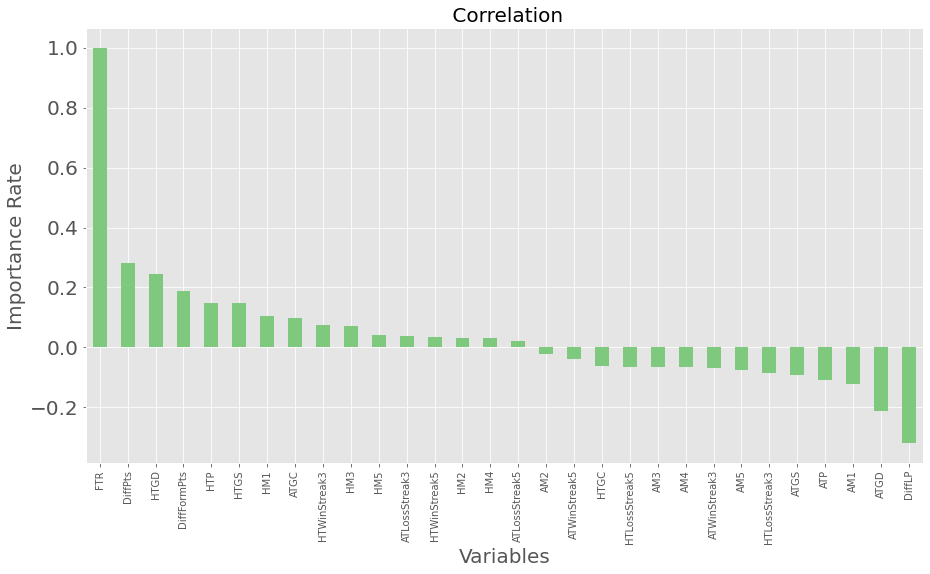

Most Positive Correlations: 
 FTR            1.000000
DiffPts        0.281677
HTGD           0.245551
DiffFormPts    0.186532
HTP            0.149372
Name: FTR, dtype: float64

Most Negative Correlations: 
 ATGS     -0.092670
ATP      -0.108805
AM1      -0.123510
ATGD     -0.213566
DiffLP   -0.320919
Name: FTR, dtype: float64


In [44]:
#VISUALISATION
import matplotlib.pyplot as plt
#df_dum.corr()['is_promoted'].sort_values(ascending = False).plot(kind='bar')
import matplotlib.cm as cm
plt.figure(figsize=(15,8))
plt.style.use('ggplot')
my_cmap = cm.get_cmap('Accent')

correlations = train.corr()['FTR'].sort_values(ascending = False)
correlations.plot(kind='bar', cmap=my_cmap)

plt.title(' Correlation',fontsize=20)
plt.xlabel('Variables', fontsize=20)
plt.ylabel('Importance Rate',fontsize=20)

plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 20) 
plt.grid(True)
plt.show() 

print('Most Positive Correlations: \n', correlations.head(5))
print('\nMost Negative Correlations: \n', correlations.tail(5))

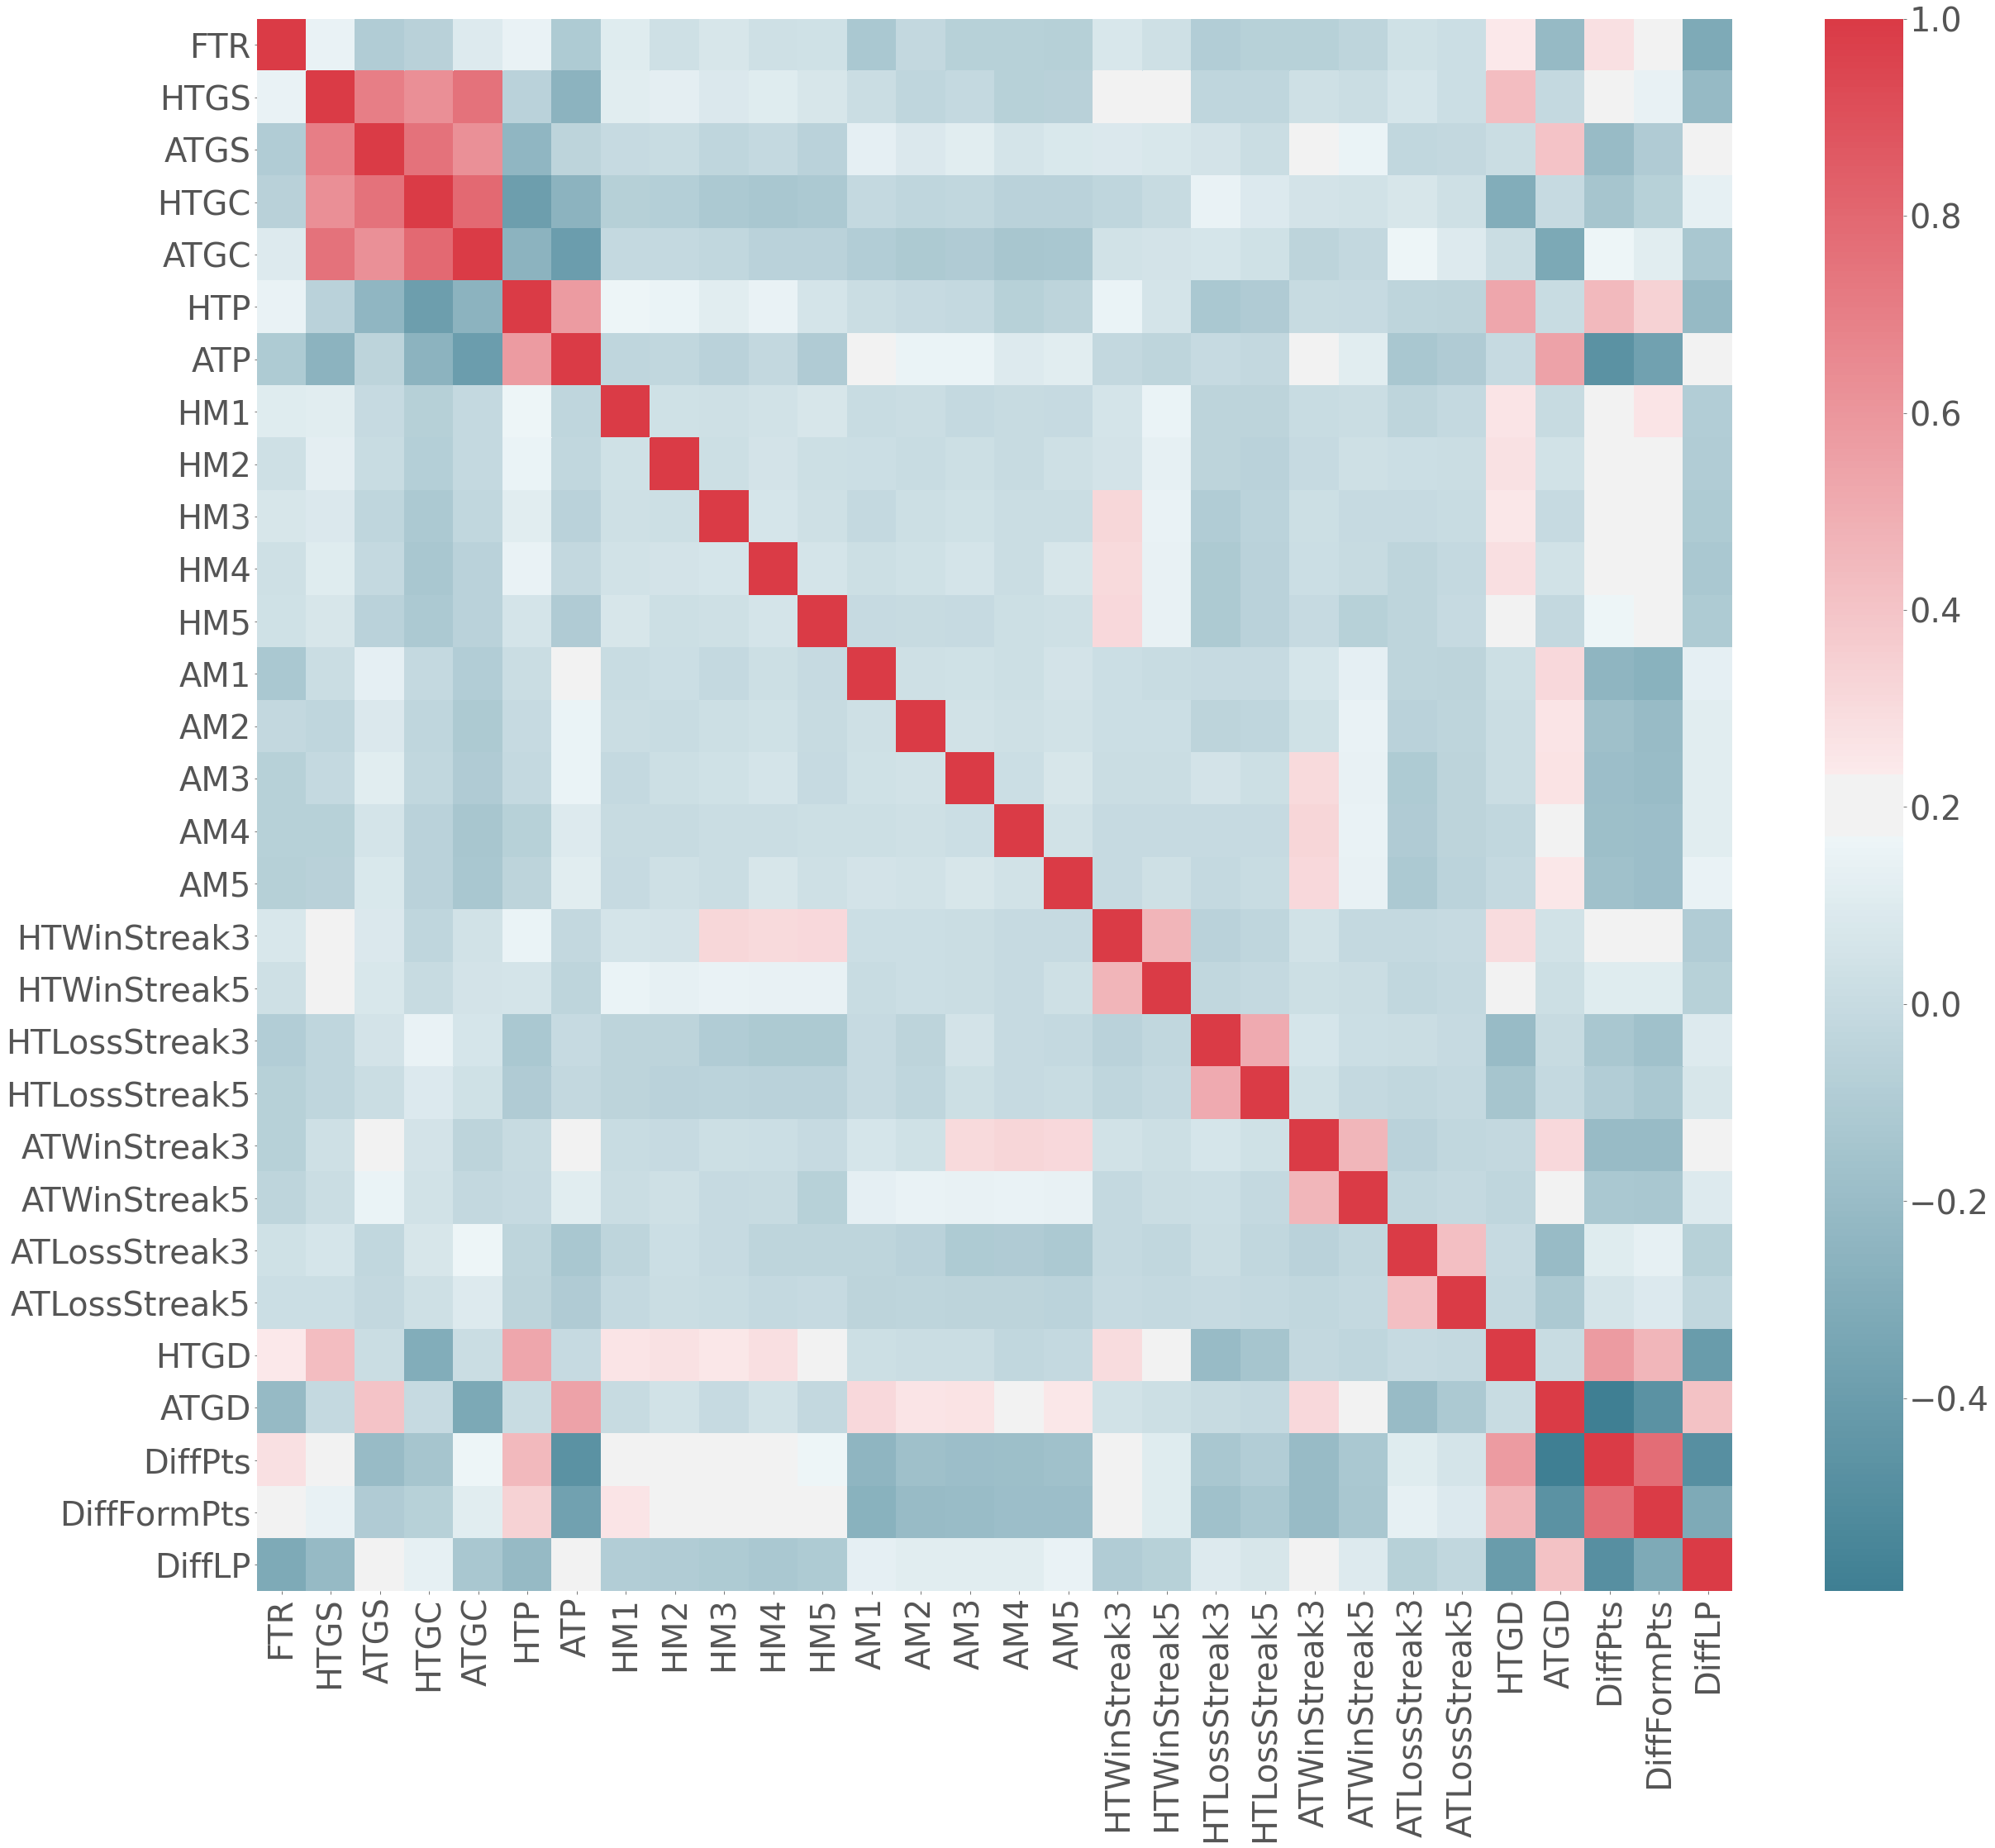

In [45]:
import seaborn as sns
cor = train.corr()
plt.figure(figsize=(40,35))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax=sns.heatmap(cor, annot=False, cmap=cmap)#cmap="YlGnBu")
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 40,rotation=90)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 40,rotation=360)
ax.figure.axes[-1].tick_params(labelsize=40)
plt.savefig('assets/correlation matrix_full_epl.png',format='png')
plt.show()